# Load Modules

In [7]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.metrics import precision_score , recall_score 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2
sns.set_style('whitegrid')
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def details(data_sent , comments = ''):
    if(comments):
        print(comments)
    sp = (data_sent.isna().sum().sum())/ data_sent.size
    print('________________________________________________')
    print('Sparsity in the data : {:.2f}'.format(sp))
    num_rows = data_sent.shape
    print('Data shape' , num_rows)
    #display(data_sent['class'].value_counts())
    print('Number of sources : ')
    cl = data_sent['class'].unique()
    for c in cl:
        num_src = len(data_sent[data_sent['class']==c]['src_id'].unique())
        num_obs = len(data_sent[data_sent['class']==c])
        print(c ,' \t ' , num_src , '\t' , num_obs)

# Load Data

In [9]:
from features import phot_flux , en_flux , hard, powlaw_fit , bb_fit , brems_fit , intra_obs_var , inter_ob_var , info_col , phot_flux_hilim , phot_flux_lolim , en_flux_hilim , en_flux_lolim

In [32]:
feat_to_use = info_col + phot_flux + phot_flux_hilim + phot_flux_lolim + en_flux + en_flux_hilim + en_flux_lolim + powlaw_fit +bb_fit +hard+ intra_obs_var +inter_ob_var 
data_cv = pd.read_csv('filtered_data/cv_new_data.csv' , index_col='obs_id')[feat_to_use]
data_cv.insert(0 , 'class' , ['CV']*len(data_cv))
data_pl  =  pd.read_csv('filtered_data/pl_new_data.csv' , index_col = 'obs_id')[feat_to_use]
data_pl.insert(0 , 'class' , ['PL']*len(data_pl))
data_lx  =  pd.read_csv('filtered_data/lmxb_data.csv' , index_col = 'obs_id')[feat_to_use]
data_lx.insert(0 , 'class' , ['LX']*len(data_lx))

In [10]:
info_col_cl =  info_col+['class']

In [6]:
# sns.histplot(data_cv['num_obs'] , color='black' , alpha = 0.3)
# sns.histplot(data_pl['num_obs'] , color='crimson' ,  alpha = 0.3)
# sns.histplot(data_lx['num_obs'] , color = 'blue' ,  alpha = 0.3)
# plt.show()

In [34]:
data = pd.concat([data_cv , data_pl , data_lx] , axis=0)
data

,class,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,...,var_inter_sigma_h,var_inter_index_m,var_inter_prob_m,var_inter_sigma_m,var_inter_index_s,var_inter_prob_s,var_inter_sigma_s,var_inter_index_u,var_inter_prob_u,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,4103.7,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_1,CV,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_2,CV,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_3,CV,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3904.6,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_4,CV,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LX,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMXB_90_obs_0,LX,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMXB_91_obs_0,LX,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,...,8.934000e-09,5.0,0.8,1.257000e-07,NaN,0.247,5.992000e-09,NaN,NaN,NaN


# Remove sparse columns

In [35]:
sp = [] 
for f in feat_to_use:
    #print(f)
    na = data[feat_to_use][f].isna().value_counts()
    try:
        sp.append(float(1-na[0]/(na[0]+na[1])))
    except:
        sp.append(0)
sp =  np.asarray(sp)
sparsity = pd.DataFrame(
    {
        "feat" : feat_to_use ,
        "sp_val" :sp
    }
).sort_values(by='sp_val' , ascending=False).reset_index(drop=True)
sparsity

,feat,sp_val
0,var_index_u,0.962617
1,kp_prob_u,0.889784
2,ks_prob_u,0.889784
3,var_max_u,0.889784
4,var_min_u,0.889784
...,...,...
101,dec,0.000000
102,livetime,0.000000
103,significance,0.000000
104,likelihood,0.000000


In [36]:
sparse_feat = sparsity[sparsity['sp_val']>0.5].sort_values(by='sp_val').reset_index(drop=True)
sparse_feat = sparse_feat['feat'].to_list()
#sparse_feat

In [37]:
dense_feat = sparsity[sparsity['sp_val']<0.5].sort_values(by='sp_val').reset_index(drop=True)
dense_feat = dense_feat['feat'].to_list()
#dense_feat

In [38]:
data_use = data[dense_feat+['class']]
details(data , 'Before removing sparse columns')
details(data_use , 'After removing sparse columns')

Before removing sparse columns
________________________________________________
Sparsity in the data : 0.44
Data shape (3103, 107)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521
After removing sparse columns
________________________________________________
Sparsity in the data : 0.21
Data shape (3103, 59)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521


## Take log

In [39]:
flux_feat = phot_flux + phot_flux_lolim + phot_flux_hilim + en_flux + en_flux_lolim + en_flux_hilim
flux_feat_avail = list(set(flux_feat) & set(dense_feat))
def take_log(data_sent):
    x_train_log = data_sent.copy()
    for f in flux_feat_avail[:]:
        x_train_log.loc[:,f] = -(np.log10(x_train_log.loc[:,f]))
    x_train_log = x_train_log.replace(-np.inf , np.nan)
    x_train_log = x_train_log.replace(np.inf , np.nan)
    return x_train_log


## Take Log of flux columns

In [12]:
df_log = take_log(data_use)
details(df_log)

________________________________________________
Sparsity in the data : 0.21
Data shape (3103, 59)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521


# all-obs imputation

## Impute entire dataset

In [13]:
data_id = df_log[info_col_cl]
data_val = df_log.drop(columns = info_col_cl)
rf_imputer = MissForest(verbose=0 , decreasing=True)
new_data = rf_imputer.fit_transform(data_val)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [14]:
new_imp_data =  pd.DataFrame(new_data , columns = data_val.columns.to_list()  , index=data_val.index.to_list())
new_imp_data.index.name = 'obs_id'

In [15]:
data_imp_v2 = pd.concat([data_id , new_imp_data] , axis=1)
data_imp_v2

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,4103.7,52.93,16618.73000,CV,...,0.53136,0.005932,0.001498,0.001964,0.000841,0.52685,0.58016,5.00,3.16,6.907958e-04
CV_0_obs_1,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,CV,...,0.55374,0.003840,0.001540,0.001922,0.000583,0.46801,0.55512,5.00,3.16,7.059176e-04
CV_0_obs_2,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,CV,...,0.78495,0.003797,0.001475,0.001905,0.000731,0.86344,0.57662,5.00,3.16,6.937636e-04
CV_0_obs_3,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3904.6,52.93,16618.73000,CV,...,0.76307,0.003645,0.001539,0.001844,0.000364,0.83576,0.57426,5.00,3.16,5.260009e-04
CV_0_obs_4,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,CV,...,0.58057,0.003647,0.001619,0.001903,0.000575,0.49683,0.54249,5.00,3.16,6.907958e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,LX,...,0.53900,0.003494,0.003420,0.003456,0.000029,0.82900,0.08400,5.25,3.05,1.710357e-05
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,LX,...,0.21100,0.003517,0.001060,0.001171,0.000255,0.26500,0.80700,5.00,3.06,1.272386e-04
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,LX,...,0.54700,0.002756,0.001488,0.001623,0.000211,0.73500,0.45100,3.00,5.00,8.766635e-07


In [11]:
data_imp_v2.to_csv('imputed_data/new-data-all-at-once-imp.csv')

NameError: name 'data_imp_v2' is not defined

In [13]:
data_imp_v2 = pd.read_csv('imputed_data/new-data-all-at-once-imp.csv' , index_col='obs_id')

In [14]:
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (3103, 59)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521


In [15]:
data_id = data_imp_v2[info_col]
data_label = data_imp_v2['class']
data_val = data_imp_v2.drop(columns=['class']+info_col)

# Combine Obs

In [16]:

df_comb = pd.DataFrame()
for s in data_imp_v2['src_id'].unique()[:]:
    temp = data_imp_v2[data_imp_v2['src_id']==s]
    temp_id =  temp[info_col_cl]
    temp_val = temp.drop(columns=info_col_cl)
    temp_mean = temp_val.mean().to_frame().T
    temp_id_top = temp_id.iloc[0:1].reset_index()
    temp_final = pd.concat([temp_id_top , temp_mean] , axis=1).set_index('obs_id')
    df_comb = df_comb.append(temp_final)
display(df_comb)


,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.600161,0.007931,0.002263,0.002978,0.001218,0.515405,0.523568,5.00,3.07375,5.417707e-04
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.636945,0.004085,0.001735,0.002451,0.000613,0.614881,0.574516,5.00,3.00000,9.789000e-07
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.677229,0.004417,0.001721,0.002179,0.000574,0.665955,0.543535,3.00,4.00000,1.081000e-06
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,0.353444,0.004808,0.003408,0.003737,0.000345,0.381742,0.226397,6.00,8.00000,7.858000e-07
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.746582,0.005740,0.002950,0.003574,0.000689,0.606845,0.558287,3.00,4.00000,1.098000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,0.539000,0.003494,0.003420,0.003456,0.000029,0.829000,0.084000,5.11,3.03000,2.125299e-05
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,0.211000,0.003517,0.001060,0.001171,0.000255,0.265000,0.807000,5.00,3.03000,2.151511e-05
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,0.547000,0.002756,0.001488,0.001623,0.000211,0.735000,0.451000,3.00,5.00000,8.482809e-07


# Normalize

In [38]:
#data_imp_norm.to_csv('all_filled_norm.csv')

In [39]:
#data_imp_v2 = pd.read_csv('imputed_data/srcwise-imp_old-data.csv' , index_col = 'obs_id')

In [17]:
data_id = df_comb[info_col]
data_label = df_comb['class']
data_val = df_comb.drop(columns=['class']+info_col)
data_imp_norm = df_comb.copy()
for c in data_val.columns.to_list():
    data_imp_norm.loc[:,c] = (data_imp_norm.loc[:,c] - data_imp_norm.loc[:,c].mean()) / data_imp_norm.loc[:,c].std()
data_imp_norm

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.140383,-0.193753,-0.407606,-0.409996,0.042725,-0.250447,0.492569,0.200236,-0.756434,0.168818
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.300193,-0.422380,-0.452348,-0.450546,-0.153447,0.182504,0.710415,0.200236,-0.795530,-0.096487
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.475208,-0.402661,-0.453504,-0.471439,-0.166164,0.404797,0.577944,-0.948770,-0.265416,-0.096436
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,-0.931496,-0.379399,-0.310762,-0.351673,-0.240642,-0.832196,-0.778104,0.774739,1.855039,-0.096581
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.776519,-0.324030,-0.349557,-0.364175,-0.128738,0.147528,0.641022,-0.948770,-0.265416,-0.096428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,-0.125336,-0.457551,-0.309760,-0.373279,-0.343210,1.114425,-1.386978,0.263431,-0.779626,-0.086540
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,-1.550353,-0.456183,-0.509419,-0.548922,-0.269642,-1.340299,1.704492,0.200236,-0.779626,-0.086412
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,-0.090579,-0.501432,-0.473210,-0.514178,-0.283957,0.705305,0.182274,-0.948770,0.264698,-0.096551


In [18]:
details(data_imp_norm)

________________________________________________
Sparsity in the data : 0.00
Data shape (420, 59)
Number of sources : 
CV  	  184 	 184
PL  	  178 	 178
LX  	  58 	 58


In [19]:
data_id = data_imp_norm[info_col]
data_label = data_imp_norm['class']
data_val = data_imp_norm.drop(columns=['class']+info_col)

In [20]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [21]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

In [22]:
clf = RandomForestClassifier(n_estimators = 1000 , n_jobs=-1)
scores = cross_val_score(clf, data_val, data_label, cv=10 , n_jobs=-1)
scores

array([0.73809524, 0.69047619, 0.69047619, 0.54761905, 0.52380952,
       0.66666667, 0.66666667, 0.73809524, 0.54761905, 0.69047619])

In [23]:
from sklearn.model_selection import permutation_test_score , StratifiedKFold

In [16]:
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    clf, data_val, data_label, scoring="accuracy", cv=cv, n_permutations=1000 , n_jobs=-1
)

NameError: name 'clf' is not defined

In [57]:
pvalue_iris

0.000999000999000999

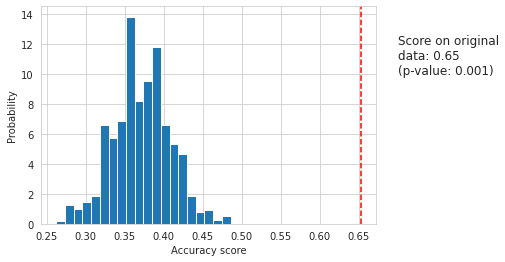

In [59]:
fig, ax = plt.subplots()

ax.hist(perm_scores_iris, bins=20, density=True)
ax.axvline(score_iris, ls="--", color="r")
score_label = f"Score on original\ndata: {score_iris:.2f}\n(p-value: {pvalue_iris:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

In [28]:
print('mean : {:.2f} \n std : {:.2f}'.format( scores.mean()   , scores.std()))

mean : 0.65 
 std : 0.06


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [27]:
verbose = 0
val_acc = []
test_acc = []
for i in tqdm(range(32)):
    src_list = pd.DataFrame()
    class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_norm.copy()
    i_val = df[info_col]
    y_val = df['class']
    x_val = df.drop(columns=['class']+info_col)
    x_train , x_test ,i_train, i_test ,  y_train , y_test = train_test_split(x_val , i_val ,y_val , test_size=0.2 , stratify=y_val, random_state=42)
    clf = RandomForestClassifier(n_estimators=200 , )
    clf.fit(x_train , y_train ,sample_weight=i_train['significance'])
    v_sc = clf.score(x_test , y_test)
    test_sc = clf.score(x_train, y_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    print(test_sc , v_sc)

  3%|▎         | 1/32 [00:00<00:21,  1.47it/s]

0.9910714285714286 0.75


  6%|▋         | 2/32 [00:01<00:20,  1.45it/s]

0.9910714285714286 0.7619047619047619


  9%|▉         | 3/32 [00:02<00:19,  1.45it/s]

0.9910714285714286 0.7380952380952381


 12%|█▎        | 4/32 [00:02<00:17,  1.58it/s]

0.9910714285714286 0.75


 16%|█▌        | 5/32 [00:03<00:16,  1.64it/s]

0.9910714285714286 0.6904761904761905


 19%|█▉        | 6/32 [00:03<00:15,  1.69it/s]

0.9910714285714286 0.7380952380952381


 22%|██▏       | 7/32 [00:04<00:14,  1.75it/s]

0.9910714285714286 0.6904761904761905


 25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

0.9910714285714286 0.7619047619047619


 28%|██▊       | 9/32 [00:05<00:12,  1.80it/s]

0.9910714285714286 0.7261904761904762


 31%|███▏      | 10/32 [00:05<00:12,  1.83it/s]

0.9910714285714286 0.7380952380952381


 34%|███▍      | 11/32 [00:06<00:11,  1.82it/s]

0.9910714285714286 0.7023809523809523


 38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

0.9910714285714286 0.7261904761904762


 41%|████      | 13/32 [00:07<00:10,  1.82it/s]

0.9910714285714286 0.7142857142857143


 44%|████▍     | 14/32 [00:07<00:09,  1.91it/s]

0.9910714285714286 0.7380952380952381


 47%|████▋     | 15/32 [00:08<00:08,  1.97it/s]

0.9910714285714286 0.7261904761904762


 50%|█████     | 16/32 [00:08<00:07,  2.03it/s]

0.9910714285714286 0.7261904761904762


 53%|█████▎    | 17/32 [00:09<00:07,  2.08it/s]

0.9910714285714286 0.7380952380952381


 56%|█████▋    | 18/32 [00:09<00:06,  2.11it/s]

0.9910714285714286 0.6666666666666666


 59%|█████▉    | 19/32 [00:10<00:06,  2.17it/s]

0.9910714285714286 0.6785714285714286


 62%|██████▎   | 20/32 [00:10<00:05,  2.18it/s]

0.9910714285714286 0.7142857142857143


 66%|██████▌   | 21/32 [00:11<00:05,  2.17it/s]

0.9910714285714286 0.7261904761904762


 69%|██████▉   | 22/32 [00:11<00:04,  2.21it/s]

0.9910714285714286 0.7142857142857143


 72%|███████▏  | 23/32 [00:12<00:04,  2.21it/s]

0.9910714285714286 0.7857142857142857


 75%|███████▌  | 24/32 [00:12<00:03,  2.22it/s]

0.9910714285714286 0.7142857142857143


 78%|███████▊  | 25/32 [00:13<00:03,  2.14it/s]

0.9910714285714286 0.7261904761904762


 81%|████████▏ | 26/32 [00:13<00:02,  2.10it/s]

0.9910714285714286 0.75


 84%|████████▍ | 27/32 [00:14<00:02,  2.07it/s]

0.9910714285714286 0.7142857142857143


 88%|████████▊ | 28/32 [00:14<00:01,  2.07it/s]

0.9910714285714286 0.7619047619047619


 91%|█████████ | 29/32 [00:14<00:01,  2.07it/s]

0.9910714285714286 0.7619047619047619


 94%|█████████▍| 30/32 [00:15<00:00,  2.07it/s]

0.9910714285714286 0.7380952380952381


 97%|█████████▋| 31/32 [00:15<00:00,  2.11it/s]

0.9910714285714286 0.7261904761904762


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]

0.9910714285714286 0.75


In [28]:
y_train.value_counts()

CV    147
PL    143
LX     46
Name: class, dtype: int64

In [29]:
y_test.value_counts()

CV    37
PL    35
LX    12
Name: class, dtype: int64

In [54]:
from sklearn.model_selection import StratifiedKFold

In [55]:
score = StratifiedKFold()

In [30]:
score = pd.DataFrame({
    "Test Score" : test_acc, 
    "Validation Score" : val_acc
})*100
score.describe().loc[['mean' , 'std' , 'min', 'max' ]]

,Test Score,Validation Score
mean,99.107143,72.953869
std,0.000000,2.605298
min,99.107143,66.666667
max,99.107143,78.571429


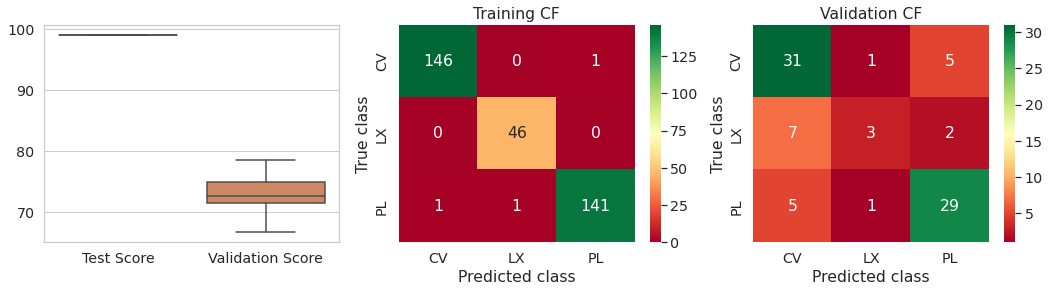

In [31]:
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols=3 , figsize = (18 , 4))
sns.boxplot(data = score , ax = ax[0])
cf = confusion_matrix(y_train , clf.predict(x_train) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[1] , xticklabels =class_to_select , yticklabels = class_to_select  , cmap='RdYlGn' ,)
cf = confusion_matrix(y_test , clf.predict(x_test) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[2] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='RdYlGn')
ax[1].set_title('Training CF')
ax[2].set_title('Validation CF')
for a in ax[1:]:
    a.set_xlabel('Predicted class')
    a.set_ylabel('True class')

plt.show()
#score

In [29]:
y_true , y_pred = y_val , clf.predict(x_val)


In [30]:
y_pred_prob = clf.predict_proba(x_val)

In [31]:
from sklearn.metrics import precision_score , recall_score , roc_auc_score

In [32]:

ps = precision_score(y_true , y_pred , average=None)
rc = recall_score(y_true , y_pred , average=None)
#auc = roc_auc_score(y_val_oh , y_pred_prob)
sc = pd.DataFrame(
    np.asarray([ps , rc]) , columns=['CV' , 'LX' , 'PL'] , index=['Precision' , 'Recall']
)
sc.index.name = 'type'
sc =sc.reset_index()
display(sc)
sc = sc.melt(id_vars=['type'] , value_vars = ['CV' , 'LX' , 'PL'])
sns.pointplot(
    data = sc , x = 'variable' , y = 'value' , hue = 'type' , join=False , ax=ax[3]
)

,type,CV,LX,PL
0,Precision,0.727273,0.714286,0.700
1,Recall,0.500000,0.666667,0.875


IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
pd.DataFrame({
    'feat' : x_train.columns.to_list() , 
    'val' : clf.feature_importances_
}).sort_values('val' , ascending=False).reset_index(drop=True)

,feat,val
0,photflux_aper_m,0.149696
1,var_inter_prob_m,0.135717
2,flux_aper_m,0.081213
3,var_inter_sigma_h,0.063748
4,var_inter_prob_s,0.054214
5,var_inter_index_h,0.043667
6,var_inter_sigma_m,0.042827
7,var_inter_sigma_b,0.036619
8,var_min_b,0.033070
9,var_inter_prob_b,0.032857
